# Smoothing Arrival Rates to Better Predict Customer Arrivals

By: Alice Paul


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

# set the random number generator
np.random.seed(7)

import pandas as pd
import datetime
from dateutil.parser import parse
import math
import numpy as np

## Question 
Our primary goal is to help Citi Bike model their bike share system between three neighborhoods, Midtown, the East Village, and the Financial District, by setting the rates of arrival for users. We have access to the average number of trips between these three neighborhoods during each half hour of the day. Our design question will be how refined should we set the rates of travel based on this data. In particular, the most refined (or least smoothed) model will set these rates by the half hour whereas the least refined (most smoothed) model will set the same rate of arrival for the whole day. This refinement is referred to as parameter smoothing and can be useful to reduce overfitting the model. 

In order to compare between models, we will assume that the primary purpose of this model is to measure the number of unhappy customers at each station. That is, the number of customers who arrive at an empty station. We want to see at what level of parameter smoothing we have the most accurate predictions for the number of unhappy customers. Less smoothing can increase the variance in the model output (yielding inaccurate predictions) whereas more smoothing can fail to capture the true dynamics (also yielding inaccurate predictions). Thus, our question is primarily a design question but the answer will be used to answer a prediction question - what is a good estimate of the number of unhappy customers?

## Model

We will use an extension of the Olin-Wellesley bike share model to answer this question. In particular, we will have three stations, East Village, Financial District, and Midtown, representing the three neighborhoods. The model will start with a starting configuration for the number of bikes at each station and a state parameter keeping track of the number of unhappy customers arriving to each station (initially zero). Then there will be Poisson arrivals of users for users wanting to bike between each pair of stations where the rate of this Poisson process will depend on the time of day and the starting and end station. If a user arrives at a non-empty station, then we move the corresponding bike, ignoring travel time. Otherwise, we record an unhappy customer. Although we are ignoring travel time and intra-neighborhood travel, we hope that these effects are roughly similar throughout the day and that it will not drastically change the answer to our parameter smoothing question. 

We chose to use a Poisson arrival process (rather than coin flips) since this distribution better reflects an arrival process and is used in the bike share literature (Jain, 2015). Most importantly, this distribution will better reflect the variance the arrivals rather than a Binomial distribution. In order to generate the next arrival of a customer wanting to travel between neighborhoods A and B, we take the time of day and average the arrival rates between that pair of stations for that time of day plus the $k$ time periods before and after, where $k$ is a parameter of the model. For $k=0$, this is equivalent to taking the rate for that exact time period (half-hour). In each iteration, the model keeps track of the current time and finds the next arriving customer. If that customer wants to go from A to B at time $t$, then the model updates the current time to $t$, the corresponding state parameters are updated, and the next arrival time for A to B is generated. 

The code for our model is below. 

In [2]:
# Global variables
trips = pd.read_csv('ave_trips_by_time.csv')
today = datetime.datetime(year=2019,day=1,month=8,hour=0, minute=0, second=0)
tomorrow = datetime.datetime(year=2019,day=2,month=8,hour=0, minute=0, second=0)
stations = ['M','E','F']

def move_bike(state,start_s,end_s):
    """Move bike, if available, otherwise update unhappy customers
    
    state: current state of the bike-share
    start_s: starting station
    end_s: end station
    """
    if state.get(start_s) == 0:
        state[start_s+'_empty'] += 1
        return
    state[start_s] -= 1
    state[end_s] += 1
        
def next_arrival(start_s, end_s, time, k):
    """Generate the next arrival between a pair of stations
    
    start_s: starting station
    end_s: end station
    time: current time of day
    k: smoothing parameter for how many time periods to average for arrival rate
    """
    time_index = int(2*time.hour+math.floor(time.minute/30.0))
    times = [time_index]
    times += [(time_index + i)%48 for i in range(1,min([25,k+1]))]
    times += [(time_index - i)%48 for i in range(1,min([24,k+1]))]
    rate = 0.
    for i in times:
        rate += trips[start_s+'-'+end_s][i]/float(30)  # rate = # arrivals/sec
    rate = rate/len(times)
    diff_sec = np.random.exponential(scale=1.0/rate)
    return time+datetime.timedelta(minutes=diff_sec)

def get_next(time_dict):
    """Find the next arrival of a customer between all stations
    
    time_dict: dictionary from tuple of stations to next arrival time
    """
    min_time = tomorrow
    min_key = (stations[0],stations[1])
    for key in time_dict.keys():
        if time_dict[key] < min_time:
            min_key = key
            min_time = time_dict[key]
    return min_key[0], min_key[1], min_time
 
def run_simulation(state,k):
    """Run bike share simulation for a single day
    
    state: starting state of the bike-share
    k: smoothing parameter for how many time periods to average for arrival rate
    """
    curr_time = today
    arrivals = dict()
    # Generate first arrivals
    for i in stations:
        for j in stations:
            if i != j:
                arrivals[(i,j)] = next_arrival(i,j,curr_time,k)
            
    while curr_time < tomorrow:
        # Find next arriving customer
        i,j,t = get_next(arrivals)
        
        # Update current time and if next day, then stop
        curr_time = t
        if t > tomorrow:
            return
        
        # Otherwise, move bike and generate next arrival
        move_bike(state,i,j)
        arrivals[(i,j)] = next_arrival(i,j,curr_time,k)

We will use this model to answer our question by running simulations for all values of $k$ and plotting the number of unhappy customers. This graph will inform how sensitive our prediction of the number of unhappy customers is to the smoothing. We validated our model by running this simulation for a reasonable starting configuration (200,200,200) and $k=0$. First, we observed that our distributions do reflect the data arrival rates. Second, the number of unhappy customers seems reasonable given the number of trips.  

## Results 
To answer the parameter smoothing question, we then want to run this simulation for all values of $k$. This requires choosing a starting configuration. For simplicity, we will assume that there are 600 bikes available (10% of the total number in 2013 reflecting roughly the proportion of trips that our data includes) and will consider all possible configurations with a multiple of 200 bikes starting at each station. This allows us to compare the models for several different starting configurations. We plot the results for the (200, 200, 200) starting configuration and give the remaining results in a table below. 

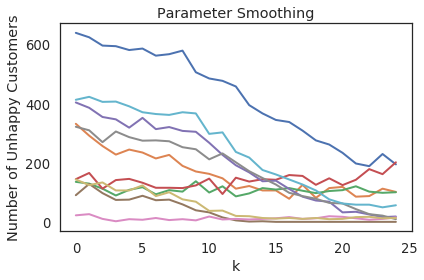

In [3]:
def find_unhappy(start_m, start_e, start_f, num_sims, plot_results = True):
    """Parameter sweep over possible values of k
    
    start_m: starting number of bikes at M
    start_e: starting number of bikes at E
    start_f: starting number of bikes at F
    """
    emp_results = np.empty(25,dtype='int')
    results = SweepSeries(data=emp_results)
    
    for k in range(25):
        results[k] = 0
        for _ in range(num_sims):
            state = State(M = start_m, E = start_e,F=start_f,M_empty=0,E_empty=0,F_empty=0)
            run_simulation(state,k)
            results[k] += state.M_empty+state.F_empty+state.E_empty
        results[k] = results[k]/num_sims
    if plot_results:
        plot(results)
        decorate(title='Parameter Smoothing',
             xlabel='k', 
             ylabel='Number of Unhappy Customers')
    return results

# Create data frame to store results
configs=['(600,0,0)','(0,600,0)','(0,0,600)','(400,200,0)','(400,0,200)','(200,400,0)',
        '(0,400,200)','(200,0,400)','(0,200,400)','(200,200,200)']
df = pd.DataFrame(np.zeros((25, 10)),columns=configs)
# Iterate over configurations
for i in range(4):
    for j in range(4-i):
        l = 3-i-j
        results = find_unhappy(200*i,200*j,200*l,num_sims=10)
        for k in range(25):
            df['('+str(200*i)+','+str(200*j)+','+str(200*l)+')'][k] = results[k]

In [4]:
df

(600,0,0)  (0,600,0)  (0,0,600)  (400,200,0)  (400,0,200)  (200,400,0)  \
0       412.0      144.0      638.0        143.0        321.0         22.0   
1       422.0      165.0      623.0        124.0        309.0         26.0   
2       405.0      112.0      595.0        133.0        269.0         10.0   
3       406.0      141.0      593.0        106.0        305.0          2.0   
4       390.0      145.0      580.0        106.0        286.0          9.0   
5       370.0      132.0      585.0        123.0        274.0          7.0   
6       364.0      115.0      561.0         87.0        275.0         13.0   
7       361.0      115.0      566.0        100.0        272.0          6.0   
8       370.0      114.0      578.0         76.0        252.0          9.0   
9       366.0      123.0      505.0         68.0        245.0          5.0   
10      297.0      146.0      484.0         37.0        211.0         18.0   
11      302.0       94.0      476.0         38.0        231.0          8.0   
12      236.0      149.0      457.0         20.0        201.0         10.0   
13      217.0      136.0      394.0         19.0        171.0          8.0   
14      175.0      144.0      366.0         13.0        148.0         10.0   
15      160.0      142.0      344.0         11.0        126.0         12.0   
16      143.0      158.0      337.0         13.0         98.0         16.0   
17      126.0      155.0      308.0         10.0         87.0         10.0   
18      106.0      125.0      275.0         13.0         78.0         12.0   
19       76.0      147.0      261.0          9.0         64.0         19.0   
20       62.0      124.0      233.0         10.0         62.0         17.0   
21       58.0      142.0      197.0         16.0         43.0         12.0   
22       58.0      178.0      188.0         17.0         26.0          7.0   
23       49.0      161.0      229.0         12.0         21.0         10.0   
24       56.0      201.0      194.0         13.0          9.0         15.0   

    (0,400,200)  (200,0,400)  (0,200,400)  (200,200,200)  
0         135.0        403.0        331.0           90.0  
1         129.0        385.0        291.0          128.0  
2         112.0        354.0        256.0           97.0  
3          89.0        346.0        227.0           74.0  
4         108.0        318.0        244.0           75.0  
5         117.0        351.0        234.0           88.0  
6          93.0        313.0        214.0           73.0  
7         107.0        320.0        226.0           75.0  
8         102.0        307.0        189.0           59.0  
9         137.0        304.0        170.0           39.0  
10         99.0        267.0        162.0           32.0  
11        120.0        226.0        147.0           15.0  
12         86.0        191.0        112.0            5.0  
13         96.0        167.0        121.0            1.0  
14        114.0        137.0        106.0            2.0  
15        109.0        139.0        106.0            0.0  
16        114.0        111.0         78.0            0.0  
17        105.0         85.0        125.0            0.0  
18         97.0         72.0         81.0            0.0  
19        104.0         68.0        114.0            0.0  
20        107.0         32.0        118.0            0.0  
21        120.0         34.0         85.0            0.0  
22        102.0         25.0         87.0            0.0  
23         98.0         16.0        112.0            0.0  
24        100.0         18.0        101.0            0.0

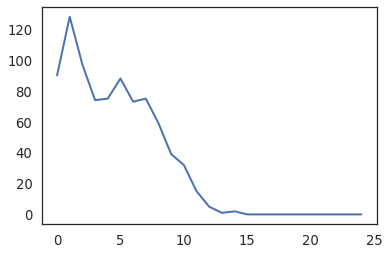

In [5]:
plot(df['(200,200,200)'])

## Interpretation
For nearly all the starting configurations, we see an interesting trend. As $k$ increases, the number of disatisfied customers goes down. This indicates that smoothing the arrival rates too much (such as using the same arrival rate for the whole day) ignores some of the important system dynamics. However, we also see that some smoothing could be beneficial in that the estimated number of unhappy customers for $k=0$ exhibits higher variance than expected. This indicates that we could be overfitting by varying the rate every 30 minutes. Based on the plots above, setting $k=3,4$ seems to be a good choice in that this reflects the same behavior as for smaller $k$ but should exhibit smoother behavior. We believe that this a valid answer since the change in the number of unhappy customers between starting conditions seems to accurately reflect the differences in demands between stations. 

One big limitation of our model is the data available. In particular, this data only reflects observed trips and so it might not reflect the true customer demand. In order to add this into the system, we would have to know when there were no bikes left in each neighborhood. Further, a more detailed and extended model to include all stations would better capture the whole system dynamics, rather than focusing on three neighborhoods. While these limitations might change the answer to the value of $k$ slightly, the techniques used could be easily extended.  